In [1]:
import sys
sys.path.append('../py')
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import yaml

from plot.results import plot_brier_skill, plot_weights

In [2]:
from datetime import datetime, timedelta

## Brier weights

In [3]:
path_weights = Path('../results/hits/2020_2023/combination/weighing')

In [4]:
weights = xr.Dataset({str(rp): xr.open_dataarray(path_weights / f'weights_brier_{rp}.nc') for rp in [2, 5, 20]})

weights

<xarray.Dataset>
Dimensions:   (leadtime: 20, model: 4)
Coordinates:
  * leadtime  (leadtime) int64 12 24 36 48 60 72 84 ... 180 192 204 216 228 240
  * model     (model) object 'COS' 'DWD' 'EUD' 'EUE'
Data variables:
    2         (model, leadtime) float64 ...
    5         (model, leadtime) float64 ...
    20        (model, leadtime) float64 ...

In [5]:
# plot the Brier skill score
top = cm.get_cmap('Blues_r', 128)
bottom = cm.get_cmap('Oranges', 128)
newcolors = np.vstack((top(np.linspace(0.2, .95, 128)),
                       bottom(np.linspace(.05, .8, 128))))
BuOr = ListedColormap(newcolors, name='BlueOrange')

In [6]:
# heatmap of weights
plot_weights(weights, cmap=BuOr, save=f'{path_weights}/brier_weights_vs_return_period.jpg')

## Hydrograph

In [7]:
models = {'COS': {'members': 20, 'leadtimes': 22},
          'DWD': {'members': 1, 'leadtimes': 28},
          'EUD': {'members': 1, 'leadtimes': 40},
          'EUE': {'members': 51, 'leadtimes': 40},}

In [8]:
with open('../conf/config_COMB_all_leadtimes.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [9]:
stn = 340
start, end = datetime(2021, 7, 10, 12), datetime(2021, 7, 25)

In [10]:
# area threshold
area_threshold = cfg.get('reporting_points', {}).get('area', 500)

# reporting points
path_stations = cfg.get('paths', {}).get('output', {}).get('reporting_points', '../results/reporting_points/')
file_stations = f'{path_stations}reporting_points_over_{area_threshold}km2.parquet'

# minimum performance required from the reporting points

In [11]:
path_dis_reanalysis = Path(cfg.get('discharge', {}).get('output', {}).get('reanalysis', f'../data/discharge/reanalysis/'))
path_dis_forecast = Path(cfg.get('discharge', {}).get('input', {}).get('forecast', f'../data/discharge/forecast/'))

In [12]:
stations = pd.read_parquet(file_stations)
stations = pd.DataFrame(stations.loc[stn]).transpose()
print('no. stations:\t\t\t{0}'.format(stations.shape[0]))

thresholds = stations[['rl1.5', 'rl2', 'rl5', 'rl20']].squeeze()

no. stations:			1


In [13]:
# load timeseries of discharge reanalysis
Qobs = xr.open_dataarray(path_dis_reanalysis / f'{stn:04}.nc').to_pandas()

# observed events
obs = (Qobs > thresholds.rl5).astype(int).loc[start + timedelta(days=10):end]
print('no. observed events:\t{0}'.format((np.diff(obs) == 1).sum()))
obs = xr.DataArray(obs, coords={'datetime': obs.index})

no. observed events:	0


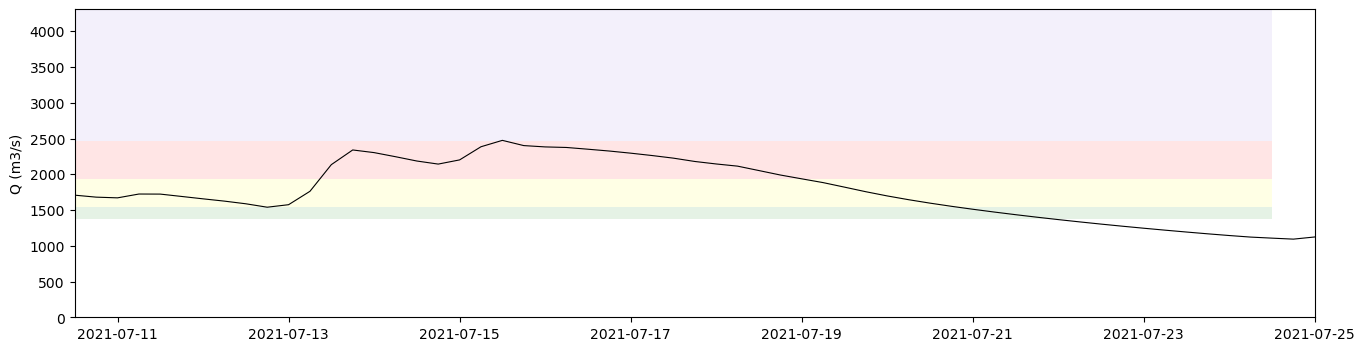

In [14]:
ymax = thresholds.rl20 * 1.75 #60

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(Qobs.index, Qobs, c='k', lw=.8, zorder=5)
if thresholds is not None:
    ax.fill_between(pd.date_range(start, end), thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
    ax.fill_between(pd.date_range(start, end), thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')
ax.set(xlim=(start, end), ylim=(0, ymax), ylabel='Q (m3/s)');

In [15]:
import matplotlib.dates as mdates

In [16]:
weights_6h = xr.DataArray(coords={'model': ['COS', 'DWD', 'EUD', 'EUE'], 'leadtime': range(6, 241, 6)},
                        dims=['model', 'leadtime'])

for lt in weights_6h.leadtime.data:
    if lt in weights['5'].leadtime.data:
        weights_6h.loc[{'leadtime': lt}] = weights['5'].sel(leadtime=lt)
    else:
        weights_6h.loc[{'leadtime': lt}] = weights['5'].sel(leadtime=6 + lt)

weights_6h

<xarray.DataArray (model: 4, leadtime: 40)>
array([[0.31783022, 0.31783022, 0.33288736, 0.33288736, 0.28706825,
        0.28706825, 0.25234781, 0.25234781, 0.23547805, 0.23547805,
        0.21105315, 0.21105315, 0.18956393, 0.18956393, 0.1728271 ,
        0.1728271 , 0.16086246, 0.16086246, 0.1555615 , 0.1555615 ,
        0.14875577, 0.14875577, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.12790401, 0.12790401, 0.08309478, 0.08309478, 0.06194778,
        0.06194778, 0.04745064, 0.04745064, 0.04070661, 0.04070661,
        0.0382358 , 0.0382358 , 0.0356261 , 0.0356261 , 0.02811069,
        0.02811069, 0.02344711, 0.02344711, 0.02340283, 0.02340283,
        0.02245365, 0.02245365, 0.02557399, 0.02557399, 0.02160219,
        0.02160219, 0.0188249 , 0.0188249 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.23511371, 0.23511371, 0.16309484, 0.16309484, 0.13488798,
        0.13488798, 0.12853833, 0.12853833, 0.11015793, 0.11015793,
        0.0976841 , 0.0976841 , 0.0801426 , 0.0801426 , 0.07266675,
        0.07266675, 0.07318121, 0.07318121, 0.06729645, 0.06729645,
        0.06294392, 0.06294392, 0.07117401, 0.07117401, 0.06626518,
        0.06626518, 0.05316851, 0.05316851, 0.04723405, 0.04723405,
        0.04291402, 0.04291402, 0.04049356, 0.04049356, 0.03787894,
        0.03787894, 0.03291206, 0.03291206, 0.02818111, 0.02818111],
       [0.31915206, 0.31915206, 0.42092302, 0.42092302, 0.51609599,
        0.51609599, 0.57166321, 0.57166321, 0.61365741, 0.61365741,
        0.65302695, 0.65302695, 0.69466737, 0.69466737, 0.72639547,
        0.72639547, 0.74250922, 0.74250922, 0.75373921, 0.75373921,
        0.76584666, 0.76584666, 0.903252  , 0.903252  , 0.91213263,
        0.91213263, 0.92800659, 0.92800659, 0.95276595, 0.95276595,
        0.95708598, 0.95708598, 0.95950644, 0.95950644, 0.96212106,
        0.96212106, 0.96708794, 0.96708794, 0.97181889, 0.97181889]])
Coordinates:
  * model     (model) <U3 'COS' 'DWD' 'EUD' 'EUE'
  * leadtime  (leadtime) int32 6 12 18 24 30 36 42 ... 210 216 222 228 234 240

In [17]:
# dis = pd.DataFrame(dtype=float)
dis_model = {}
for model in models:
    # open dataaray with dicharge data
    file = path_dis_forecast / model / '2021/07' / f'{model}2021071200.nc'
    da = xr.open_dataarray(file).isel(time=slice(1, None))
    da['time'] = da.time - np.timedelta64(6, 'h')
    # limit the forecast to its maximum leadtime
    if len(da.time) > models[model]['leadtimes']:
        da = da.isel(time=slice(None, models[model]['leadtimes']))
    if model == 'EUE':
        time = da.time.data.copy()
    da = da.rename({'time': 'leadtime'})
    da['leadtime'] = range(6, models[model]['leadtimes'] * 6 + 1, 6)
    df = da.sel(stations=str(stn)).to_pandas()
    if isinstance(df, pd.Series):
        df = pd.DataFrame(df).transpose()
    df.index = [f'{model}-{i:02}' for i, idx in enumerate(df.index)]
    dis_model[model] = df
    # dis = pd.concat((dis, df), axis=0)

dis = pd.concat([df for model, df in dis_model.items()], axis=0)

In [19]:
dis[lt]

COS-00            NaN
COS-01            NaN
COS-02            NaN
COS-03            NaN
COS-04            NaN
             ...     
EUE-46    1510.065918
EUE-47    1249.819336
EUE-48    1582.629517
EUE-49    1427.431519
EUE-50    1394.840088
Name: 240, Length: 73, dtype: float32

In [18]:
combination = 'member weighted'

fig, ax = plt.subplots(figsize=(12, 4))
for lt in dis.columns:
    ax.boxplot(dis[lt].dropna(),
               positions=[lt],
               widths=4,
               patch_artist=True,
               boxprops={'facecolor': 'lightgray'},
               medianprops={'color': 'black'},
               flierprops=dict(markersize=0));
if thresholds is not None:
    x = [0, 246]
    ax.fill_between(x, thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
    ax.fill_between(x, thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
    ax.fill_between(x, thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
    ax.fill_between(x, thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')

ax.set(xlim=x, ylim=(0, ymax), ylabel='Q (m3/s)')
# ax.set_xticks(dis.columns[::4], labels=time[::4])
ax.set_xticklabels([])
ax.set_title('member weighted');

ax.set_title(combination);
plt.savefig(f'{combination}_boxplot.jpg', dpi=300, bbox_inches='tight')

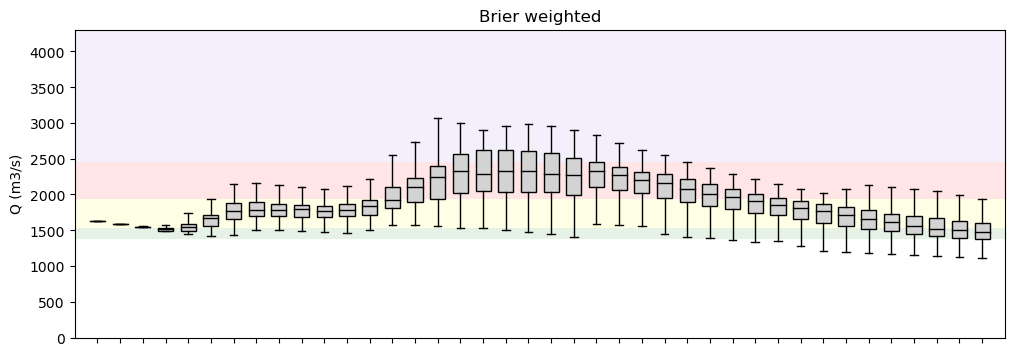

In [20]:
combination = 'Brier weighted'

fig, ax = plt.subplots(figsize=(12, 4))
for lt in dis.columns:
    # discharge values
    q = dis[lt].dropna().sort_values()
    members = q.shape[0]
    # print(lt, members)

    # weights
    w = weights_6h.sel(leadtime=lt).to_pandas()
    w = pd.Series({model: v / models[model]['members'] for model, v in w.items()})
    
    assert np.isclose(np.sum([v * models[model]['members'] for model, v in w.items()]), 1., rtol=1e-3), 'The sum of weights is not 1'
    
    # cumulative probability of non-exceedance
    p = pd.Series([w[idx.split('-')[0]] for idx in q.index], index=q.index).cumsum()
    
    assert np.isclose(p.max(), 1., rtol=1e-3), 'The cumulative non-exceedance probability is not 1'
    
    # discharge quantiles
    idx = [(p - x).abs().idxmin() for x in [.25, .5, .75]]
    quantiles = q.loc[idx].to_list()
    # whiskers
    iqr = quantiles[2] - quantiles[0]
    lw = max(quantiles[0] - 1.5 * iqr, q.min())
    uw = min(quantiles[2] + 1.5 * iqr, q.max())

    data = [lw] + quantiles + [uw]
    plt.boxplot(data,
               positions=[lt],
               widths=4,
               patch_artist=True,
               boxprops={'facecolor': 'lightgray'},
               medianprops={'color': 'black'},
               flierprops=dict(markersize=0))
if thresholds is not None:
    x = [0, 246]
    ax.fill_between(x, thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
    ax.fill_between(x, thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
    ax.fill_between(x, thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
    ax.fill_between(x, thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')

ax.set(xlim=x, ylim=(0, ymax), ylabel='Q (m3/s)')
ax.set_xticklabels([])
ax.set_title(combination);

plt.savefig(f'{combination}_boxplot.jpg', dpi=300, bbox_inches='tight')

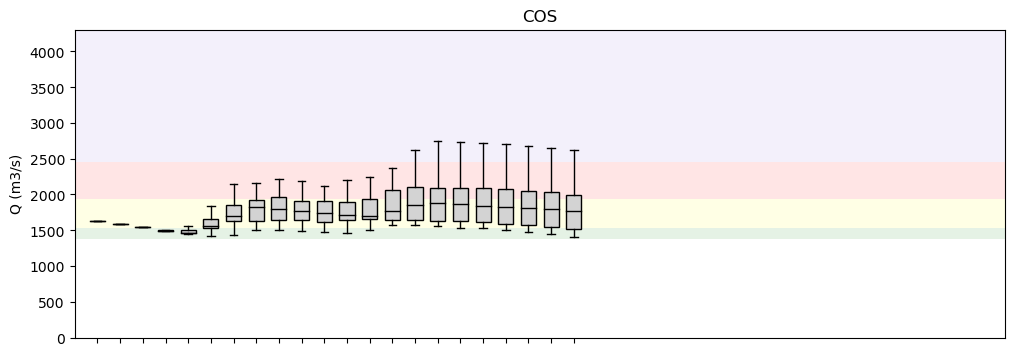

In [365]:
model = 'COS'

fig, ax = plt.subplots(figsize=(12, 4))
for lt in dis_model[model].columns:
    ax.boxplot(dis_model[model][lt],
               positions=[lt],
               widths=4,
               patch_artist=True,
               boxprops={'facecolor': 'lightgray'},
               medianprops={'color': 'black'},
               flierprops=dict(markersize=0));
if thresholds is not None:
    x = [0, 246]
    ax.fill_between(x, thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
    ax.fill_between(x, thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
    ax.fill_between(x, thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
    ax.fill_between(x, thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')

ax.set(xlim=x, ylim=(0, ymax), ylabel='Q (m3/s)')
ax.set_xticklabels([])
ax.set_title(model);

plt.savefig(f'{model}_boxplot.jpg', dpi=300, bbox_inches='tight')

In [366]:
model = 'EUE'

fig, ax = plt.subplots(figsize=(12, 4))
for lt in dis_model[model].columns:
    ax.boxplot(dis_model[model][lt],
               positions=[lt],
               widths=4,
               patch_artist=True,
               boxprops={'facecolor': 'lightgray'},
               medianprops={'color': 'black'},
               flierprops=dict(markersize=0));
if thresholds is not None:
    x = [0, 246]
    ax.fill_between(x, thresholds['rl1.5'], thresholds['rl2'], color='green', edgecolor=None, alpha=.1, zorder=0, label='1.5-year')
    ax.fill_between(x, thresholds['rl2'], thresholds['rl5'], color='yellow', edgecolor=None, alpha=.1, zorder=0, label='2-year')
    ax.fill_between(x, thresholds['rl5'], thresholds['rl20'], color='red', edgecolor=None, alpha=.1, zorder=0, label='5-year')
    ax.fill_between(x, thresholds['rl20'], ymax, color='mediumpurple', edgecolor=None, alpha=.1, zorder=0, label='20-year')

ax.set(xlim=x, ylim=(0, ymax), ylabel='Q (m3/s)')
ax.set_xticklabels([])
ax.set_title(model);

plt.savefig(f'{model}_boxplot.jpg', dpi=300, bbox_inches='tight')